In [ ]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import warnings
warnings.filterwarnings('ignore')

# 2. Load and Inspect Data
df = pd.read_csv("Housing_Macroeconomic_Factors_US.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print("Data shape:", df.shape)
df.head()

Data shape: (425, 13)


,Date,house_price_index,population,house_supply,gdp,mortgage_rate,employment_rate,permit_new,ppi_res,m3,cci,delinquency_rate,hcai
0,1987-01-01,63.965,241857,6.0,99.902813,9.2040,70.163085,1690.0,100.0,2.7439,100.4624,NaN,NaN
1,1987-02-01,64.424,242005,6.2,99.875864,9.0825,70.289205,1689.0,100.4,2.7475,100.4945,NaN,NaN
2,1987-03-01,64.735,242166,6.0,99.869734,9.0350,70.321678,1704.0,100.7,2.7537,100.5720,NaN,NaN
3,1987-04-01,65.132,242338,6.0,99.882087,9.8325,70.499062,1601.0,101.1,2.7677,100.6568,NaN,NaN
4,1987-05-01,65.565,242516,6.7,99.910371,10.5960,70.808308,1500.0,101.3,2.7729,100.6919,NaN,NaN


In [ ]:
# 3. Preprocessing
# Drop columns with too many missing values (e.g., 'hcai')
df = df.drop(columns=['hcai'])

# Fill remaining missing values (forward fill)
df.fillna(method='ffill', inplace=True)

n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

train = df.iloc[:train_end]
validation = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

# Define target and features
target = 'house_price_index'
features = df.columns.drop(['Date', target])

# Create feature and target sets for each split
X_train = train[features]
y_train = train[target]

X_val = validation[features]
y_val = validation[target]

X_test = test[features]
y_test = test[target]


In [ ]:
# 4. Time Series Cross-Validation & Hyperparameter Tuning

# Use expanding window TimeSeriesSplit for robust evaluation
tscv = TimeSeriesSplit(n_splits=5)

# Define an XGBoost regressor with a squared error objective
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Create a grid of hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Setup GridSearchCV using the time series split
grid_search = GridSearchCV(xgb_model, param_grid, cv=tscv,
                           scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from the grid search
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)



Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [ ]:
# 5. Model Evaluation on Validation and Test Sets

# Validation set evaluation
y_val_pred = best_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print("\nValidation Metrics:")
print(f"RMSE: {rmse_val:.3f}")
print(f"MAE: {mae_val:.3f}")
print(f"R²: {r2_val:.3f}")

# Test set evaluation
y_test_pred = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nTest Metrics:")
print(f"RMSE: {rmse_test:.3f}")
print(f"MAE: {mae_test:.3f}")
print(f"R²: {r2_test:.3f}")


Validation Metrics:
RMSE: 20.662
MAE: 16.550
R²: -0.870

Test Metrics:
RMSE: 81.210
MAE: 72.879
R²: -5.599


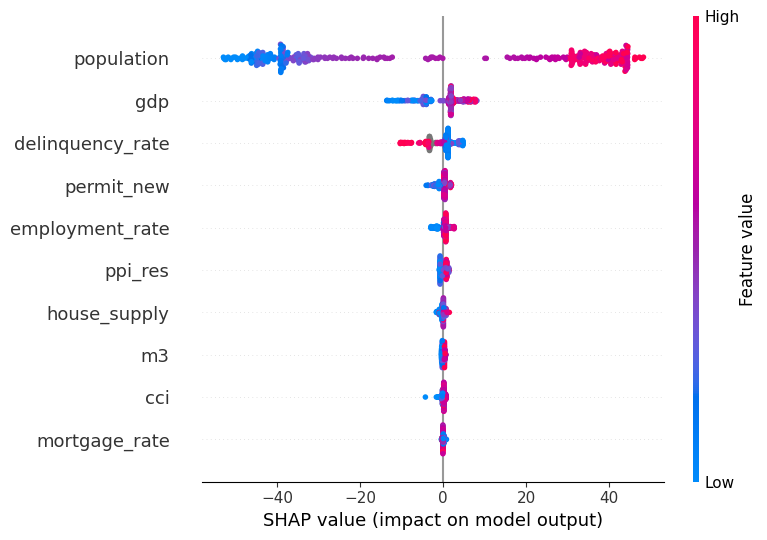

In [ ]:
# 6. Final Training on Train + Validation and SHAP Analysis

# Combine training and validation sets for final model training
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Retrain the final model with best hyperparameters on combined data
final_model = XGBRegressor(objective='reg:squarederror', random_state=42, **grid_search.best_params_)
final_model.fit(X_train_val, y_train_val)

# Initialize SHAP explainer
explainer = shap.Explainer(final_model)
shap_values = explainer(X_train_val)

# Plot SHAP summary plot to show feature importances
plt.figure()
shap.summary_plot(shap_values, X_train_val, show=False)
plt.tight_layout()
plt.show()
